### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the Dataset

In [2]:
data = pd.read_csv("QVI_data.csv")

### Data Preparation

In [3]:
# Examining the data set
print(data.head())
print(data.info())

   LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000  2018-10-17          1       1         5   
1            1002  2018-09-16          1       2        58   
2            1003  2019-03-07          1       3        52   
3            1003  2019-03-08          1       4       106   
4            1004  2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstrea

In [4]:
# Chaning the Date data type to date-time object
data["DATE"] = pd.to_datetime(data["DATE"])

In [5]:
# Filtering Suitable Stores who have sales for all the months
data2 = data.copy()
data2["Month_Year"] = data2["DATE"].dt.to_period("M")
monthly_counts_of_stores = data2.groupby("STORE_NBR")["Month_Year"].nunique()
suitable_stores = monthly_counts_of_stores[monthly_counts_of_stores==12].index
suitable_stores = data[data["STORE_NBR"].isin(suitable_stores)]

### Comperative Metrics

In [6]:
key_metrics=suitable_stores.groupby(['STORE_NBR', pd.Grouper(key='DATE', freq='ME')]).agg(
    monthly_sales=('TOT_SALES', 'sum'),
    monthly_customers=('LYLTY_CARD_NBR', 'nunique'),
    monthly_transactions_per_customer=('TXN_ID', 'nunique')
).reset_index()
key_metrics['monthly_transactions_per_customer']=key_metrics['monthly_transactions_per_customer']/key_metrics['monthly_customers']
before_trial = key_metrics[key_metrics['DATE'] < '2019-02-01']

### Functions

In [7]:
# create function to check the correlation between metrics for trial stores and other stores
def metric_cor(data, metric,trial_store):
    metric_data=data[['DATE','STORE_NBR',metric]]
    metric_data = metric_data.pivot_table(index='DATE', columns='STORE_NBR', values=metric)
    trial_store_cor= metric_data.corr()[trial_store].drop([77,86,88],axis=0)
    return (trial_store_cor)

In [8]:
# create a function to quantify the difference between a key metric for a trial store and other stores
def metric_diff(data, metric,trial_store):
    metric_data=data[['DATE','STORE_NBR',metric]]
    metric_data = metric_data.pivot_table(index='DATE', columns='STORE_NBR', values=metric)
    trial_store_diff= np.delete(np.linalg.norm(metric_data.sub(metric_data.loc[:, trial_store], axis=0), axis=0),[76,85,87])
    trial_store_diff=1- ((trial_store_diff - np.min(trial_store_diff)) / (np.max(trial_store_diff) - np.min(trial_store_diff)))
    return (trial_store_diff)

In [9]:
# lets create an average of correlation and difference for two key metrics

# examining for store 77
# Trial Store
monthly_sales77=((metric_cor (before_trial, 'monthly_sales',77))+(metric_diff (before_trial, 'monthly_sales',77)))/2
monthly_customers77=((metric_cor (before_trial, 'monthly_customers',77))+(metric_diff (before_trial, 'monthly_customers',77)))/2
print(np.argmax((monthly_sales77+monthly_customers77)/2))
# Control Store
print((metric_cor (before_trial, 'monthly_sales',77)).reset_index().iloc[218,0])

# examining for store 86
# Trial Store
monthly_sales86=((metric_cor (before_trial, 'monthly_sales',86))+(metric_diff (before_trial, 'monthly_sales',86)))/2
monthly_customers86=((metric_cor (before_trial, 'monthly_customers',86))+(metric_diff (before_trial, 'monthly_customers',86)))/2
print(np.argmax((monthly_sales86+monthly_customers86)/2))
# Control Store
print((metric_cor (before_trial, 'monthly_sales',86)).reset_index().iloc[144,0])

# examining for store 88
# Trial Store
monthly_sales88 = ((metric_cor(before_trial, 'monthly_sales', 88)) + (metric_diff(before_trial, 'monthly_sales', 88))) / 2
monthly_customers88 = ((metric_cor(before_trial, 'monthly_customers', 88)) + (metric_diff(before_trial, 'monthly_customers', 88))) / 2
print(np.argmax((monthly_sales88 + monthly_customers88)/2))
# Control Store
print((metric_cor (before_trial, 'monthly_sales',88)).reset_index().iloc[222,0])

218
233
144
155
222
237


### Visualizing

In [10]:
# create a function to vizualize the trends in a metric for a trial store, its control and the aggregate of other stores
def control_viz(data, metric,trial_store,control):
    metric_data=data[['DATE','STORE_NBR',metric]]
    metric_data = metric_data.pivot_table(index='DATE', columns='STORE_NBR', values=metric)
    to_drop=[77,86,88]
    to_drop.remove(trial_store)
    metric_data = metric_data.drop(columns=to_drop,axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(metric_data.index, metric_data[trial_store], label='trial store')
    plt.plot(metric_data.index, metric_data[control], label='control store')
    plt.plot(metric_data.index, metric_data.drop(columns=[trial_store, control]).mean(axis=1), label='other stores mean')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.title(f'{metric} Trend for Each Store')
    plt.legend()
    plt.show()

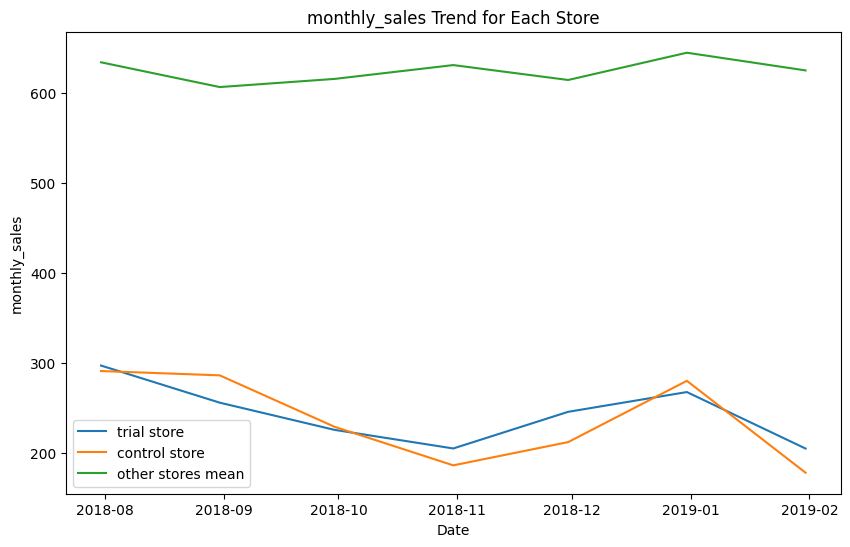

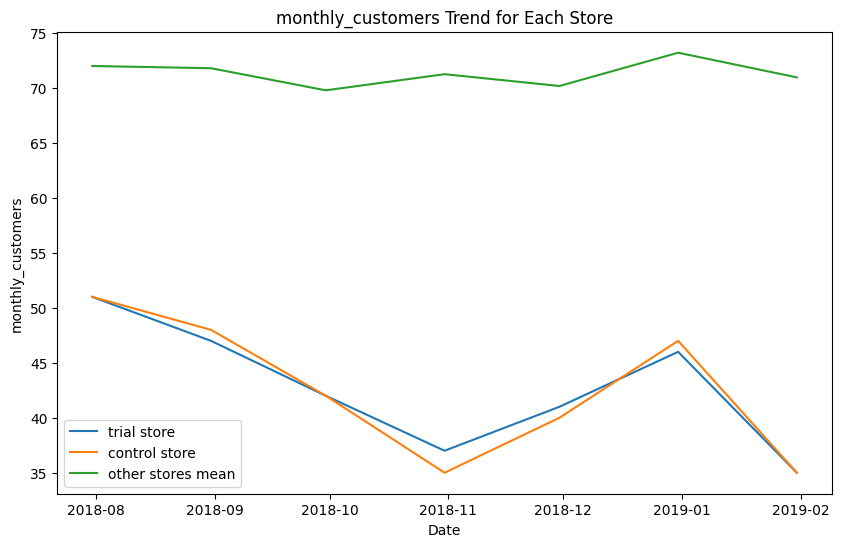

In [11]:
# monthly sales for store 77
control_viz(before_trial, 'monthly_sales',77,233)
# number of customers for store 77
control_viz(before_trial, 'monthly_customers',77,233)

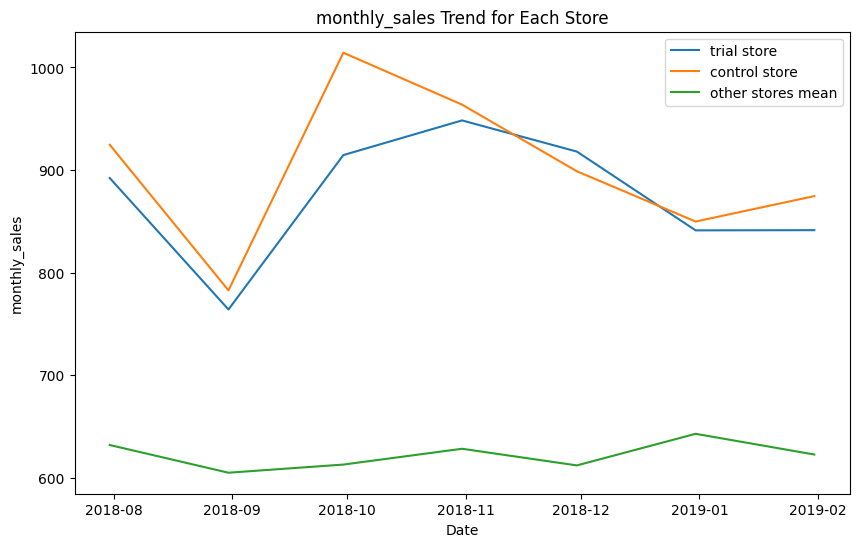

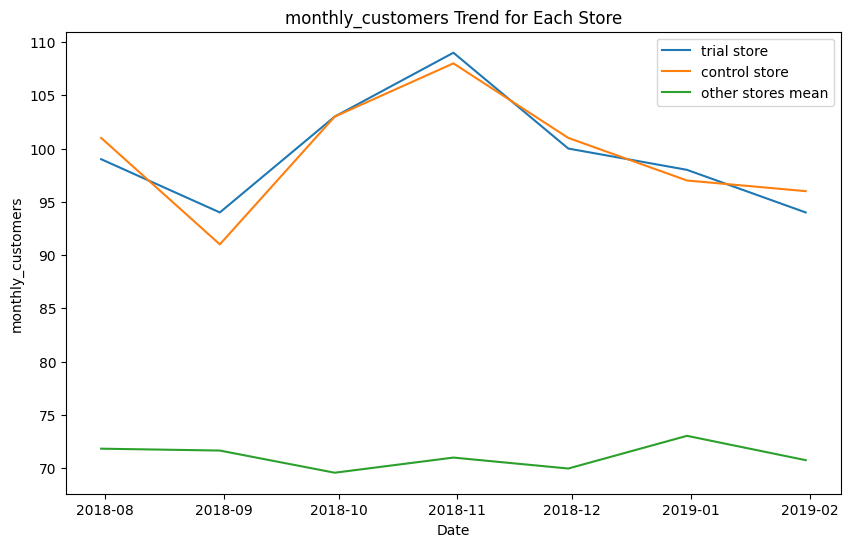

In [12]:
# monthly sales for store 86
control_viz(before_trial, 'monthly_sales',86,155)
# number of customers for store 86
control_viz(before_trial, 'monthly_customers',86,155)

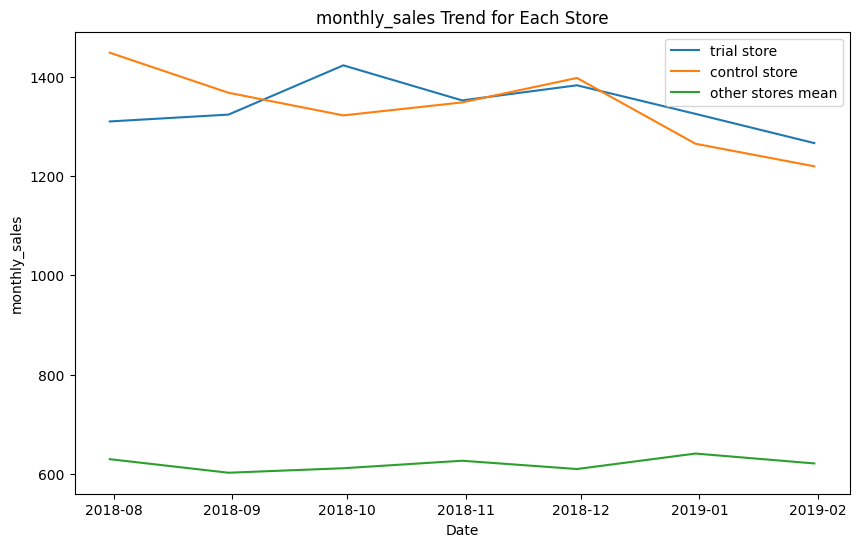

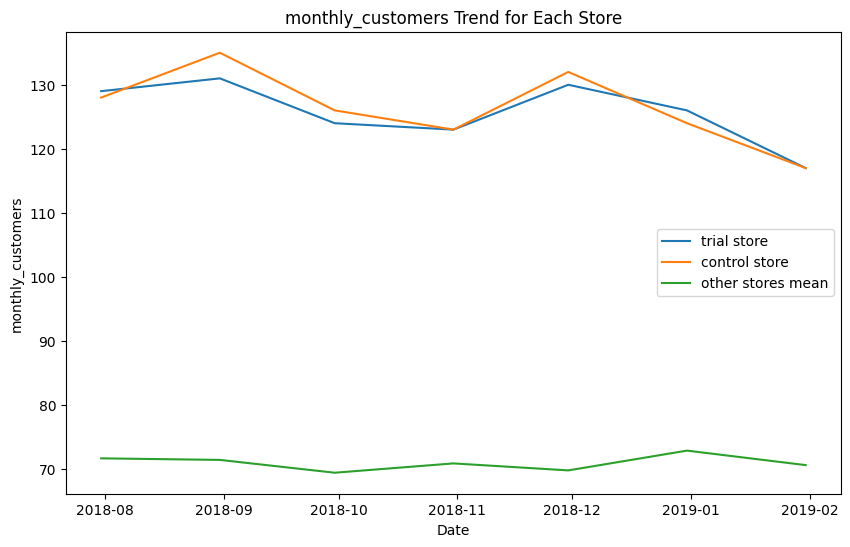

In [13]:
# number of customers for store 88
control_viz(before_trial, 'monthly_sales',88,237)
# number of customers for store 88
control_viz (before_trial, 'monthly_customers',88,237)

### Trial & Control Stores Comparision 

In [14]:
# create a function that visualizes the effect of the experiment on the performance of the trial store compared to the control store
def trial_comp(df, trial_store, control_store, metric):
    before_trial = df[df['DATE'] < '2019-02-01']
    scaler=(before_trial[before_trial['STORE_NBR'] == trial_store][metric].sum())/(before_trial[before_trial['STORE_NBR'] == control_store][metric].sum())
    key_metrics_control=df[df['STORE_NBR'] == control_store]
    key_metrics_control.loc[:,metric]= key_metrics_control[metric].copy()*scaler
    comp_df=pd.concat([key_metrics_control[['DATE','STORE_NBR',metric]],(df[['DATE','STORE_NBR',metric]][df['STORE_NBR'] == trial_store])],axis=0)
    comp_df= comp_df.pivot_table(index='DATE', columns='STORE_NBR', values=metric)
    comp_df['Percentage_Difference'] = ((comp_df[trial_store] - comp_df[control_store]) / comp_df[trial_store]) * 100
    plt.figure(figsize=(10, 6))
    comp_df['Percentage_Difference'].plot(marker='o', color='b', linestyle='-')
    comp_df.loc['2019-02-28':'2019-04-30', 'Percentage_Difference'].plot(marker='o', color='r', linestyle='-')
    plt.title(f'{metric} Percentage Difference Trend')
    plt.xlabel('Date')
    plt.ylabel(f'{metric} Percentage Difference (%)')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    abs_mean_per_diff_trial = np.abs(comp_df.loc['2019-02-28':'2019-04-30', 'Percentage_Difference']).mean()
    abs_mean_per_diff_out_trial= np.abs(comp_df.loc[~comp_df.index.isin(['2019-02-28', '2019-03-31', '2019-04-30']), 'Percentage_Difference']).mean()
    mean_per_diff_trial = comp_df.loc['2019-02-28':'2019-04-30', 'Percentage_Difference'].mean()
    mean_per_diff_out_trial = comp_df.loc[~comp_df.index.isin(['2019-02-28', '2019-03-31', '2019-04-30']), 'Percentage_Difference'].mean()
    return(abs_mean_per_diff_trial, abs_mean_per_diff_out_trial, mean_per_diff_trial, mean_per_diff_out_trial)

In [15]:
# create a function that visualizes the effect of the experiment on the performance of the trial store compared to the control store
def trial_comp(df, trial_store, control_store, metric):
    # Convert DATE column to datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Define trial period start
    before_trial = df[df['DATE'] < '2019-02-01']

    # Compute scaling factor based on pre-trial period
    scaler = (before_trial[before_trial['STORE_NBR'] == trial_store][metric].sum()) / \
             (before_trial[before_trial['STORE_NBR'] == control_store][metric].sum())

    # Scale the control store metric (Ensure float conversion to avoid dtype issues)
    key_metrics_control = df[df['STORE_NBR'] == control_store].copy()
    # Convert metric column to float before applying the scaler
    key_metrics_control[metric] = key_metrics_control[metric].astype(float) * scaler

    # Merge trial and control store data
    comp_df = pd.concat([
        key_metrics_control[['DATE', 'STORE_NBR', metric]],
        df[df['STORE_NBR'] == trial_store][['DATE', 'STORE_NBR', metric]]
    ], axis=0)

    # Pivot to have stores as columns
    comp_df = comp_df.pivot_table(index='DATE', columns='STORE_NBR', values=metric)

    # Calculate percentage difference
    comp_df['Percentage_Difference'] = ((comp_df[trial_store] - comp_df[control_store]) / comp_df[trial_store]) * 100

    # Define trial period and exclude dates properly
    trial_period = ('2019-02-28', '2019-04-30')
    exclude_dates = pd.to_datetime(['2019-02-28', '2019-03-31', '2019-04-30'])

    # Plot the trend
    plt.figure(figsize=(10, 6))
    comp_df['Percentage_Difference'].plot(marker='o', color='b', linestyle='-', label="Overall Trend")
    comp_df.loc[trial_period[0]:trial_period[1], 'Percentage_Difference'].plot(marker='o', color='r', linestyle='-', label="Trial Period")
    
    plt.title(f'{metric} Percentage Difference Trend')
    plt.xlabel('Date')
    plt.ylabel(f'{metric} Percentage Difference (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute statistics
    abs_mean_per_diff_trial = np.abs(comp_df.loc[trial_period[0]:trial_period[1], 'Percentage_Difference']).mean()
    abs_mean_per_diff_out_trial = np.abs(comp_df.loc[~comp_df.index.isin(exclude_dates), 'Percentage_Difference']).mean()
    mean_per_diff_trial = comp_df.loc[trial_period[0]:trial_period[1], 'Percentage_Difference'].mean()
    mean_per_diff_out_trial = comp_df.loc[~comp_df.index.isin(exclude_dates), 'Percentage_Difference'].mean()

    return abs_mean_per_diff_trial, abs_mean_per_diff_out_trial, mean_per_diff_trial, mean_per_diff_out_trial


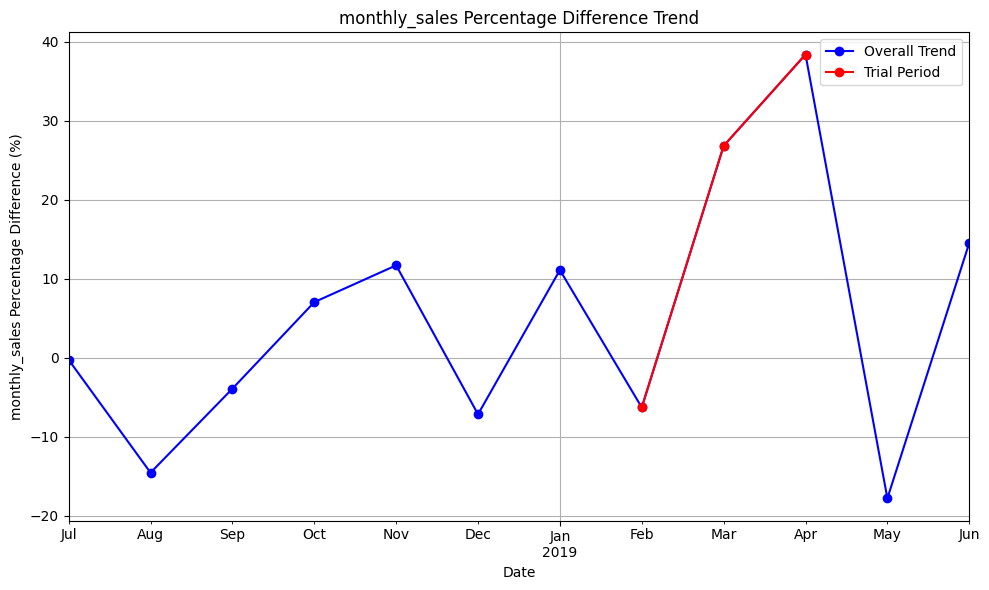

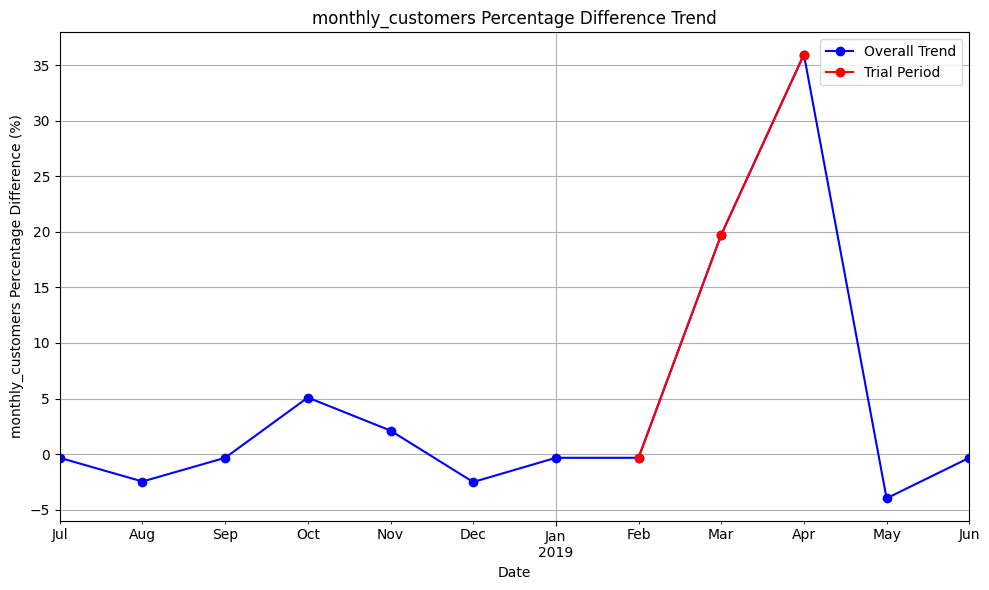

(np.float64(18.67437764767481),
 np.float64(1.9459088176501982),
 np.float64(18.450664001142364),
 np.float64(-0.34599494076791254))

In [16]:
# examining monthly sales for store 77 and its control store
trial_comp(key_metrics, 77, 233, 'monthly_sales')
# examining monthly customers for store 77 and its control store
trial_comp(key_metrics, 77, 233, 'monthly_customers')

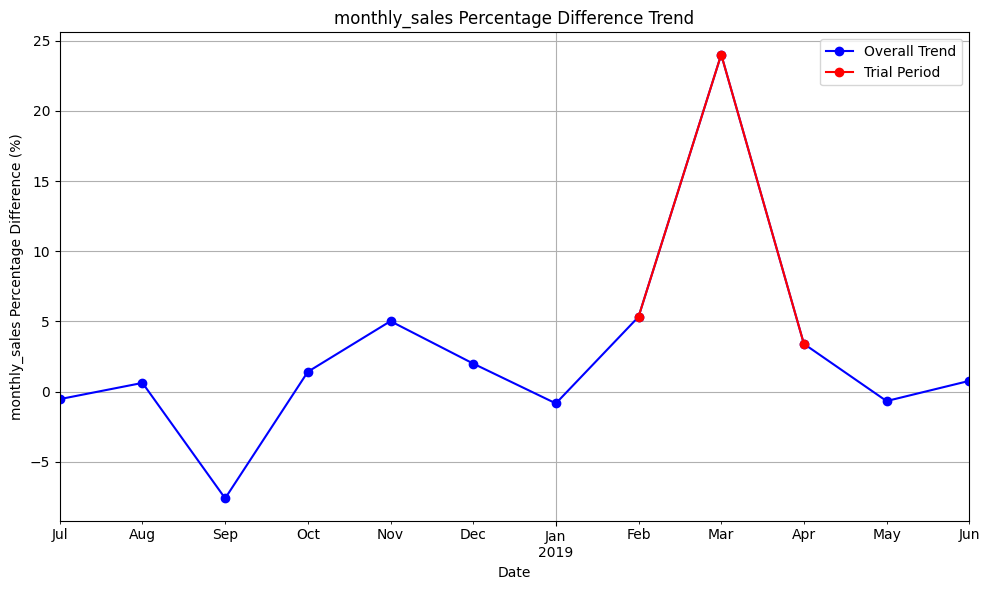

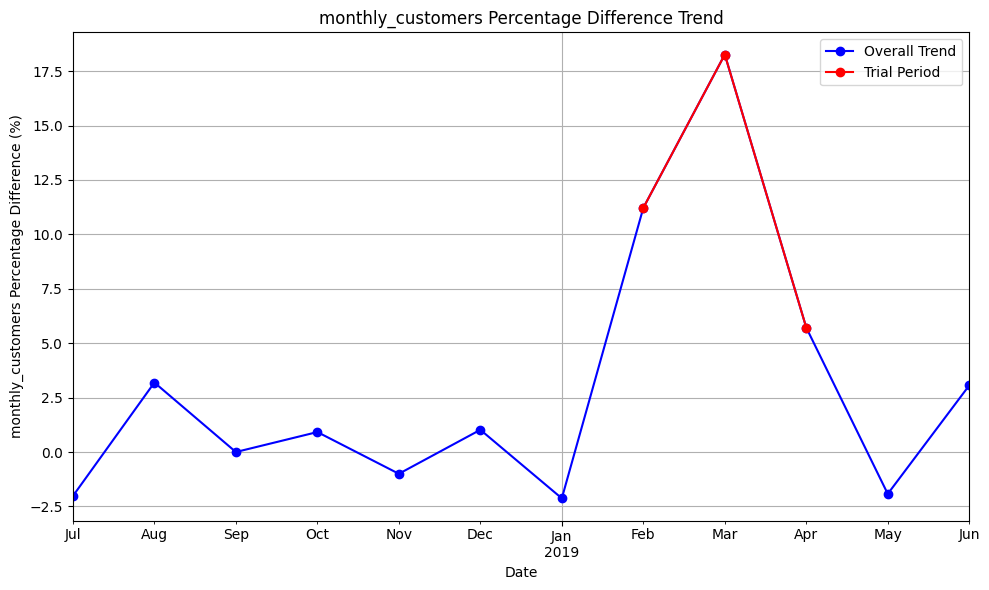

(np.float64(11.73003618351038),
 np.float64(1.6957213027967701),
 np.float64(11.73003618351038),
 np.float64(0.1244016321863193))

In [17]:
# examining monthly sales for store 86 and its control store
trial_comp(key_metrics, 86, 155, 'monthly_sales')
# examining monthly customers for store 86 and its control store
trial_comp(key_metrics, 86, 155, 'monthly_customers')

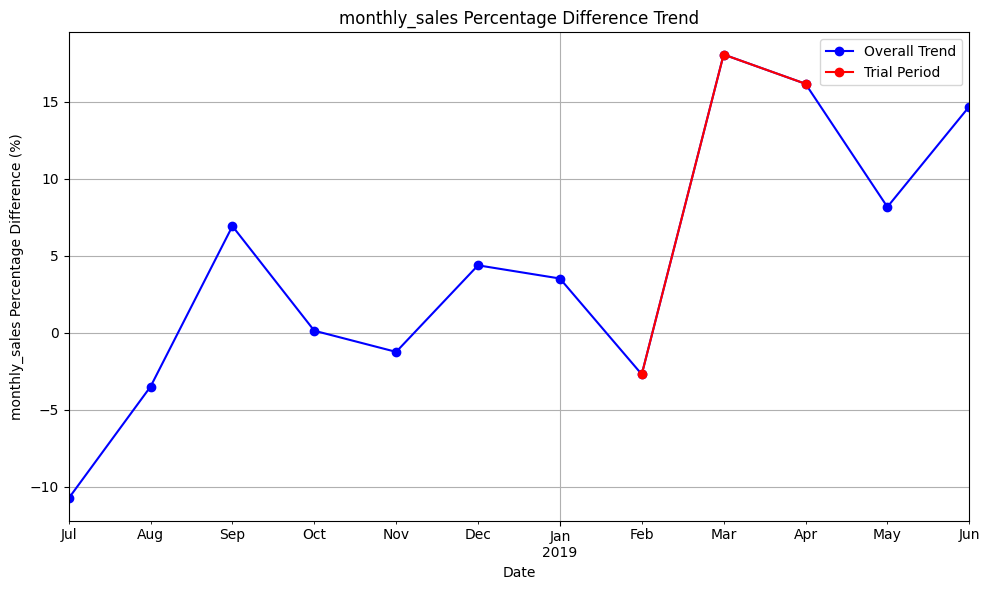

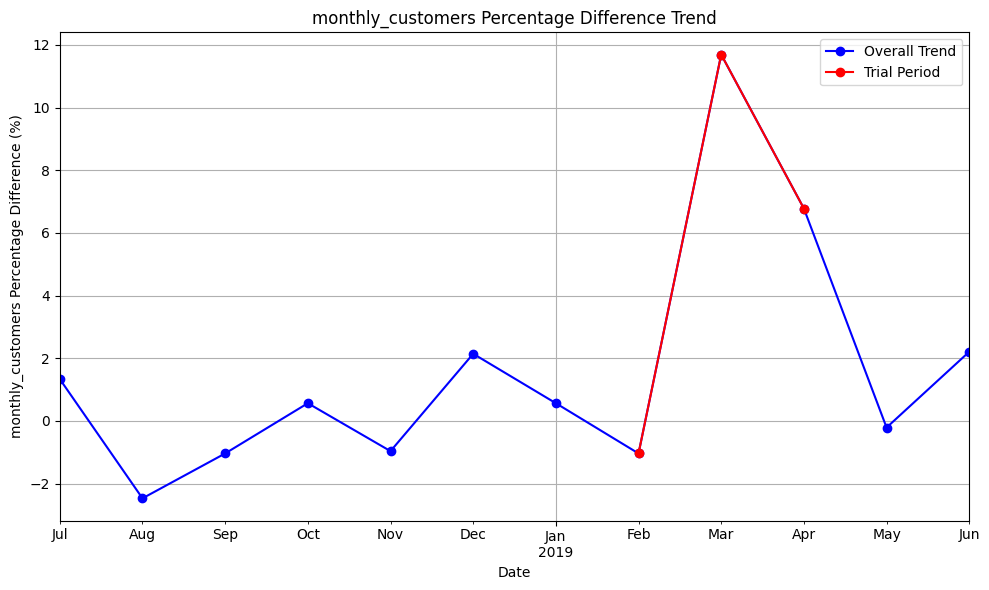

(np.float64(6.504746179799017),
 np.float64(1.2782505068833288),
 np.float64(5.812200161938616),
 np.float64(0.23676302582388942))

In [18]:
# examining monthly sales for store 88 and its control store
trial_comp(key_metrics, 88, 237, 'monthly_sales')
# examining monthly customers for store 88 and its control store
trial_comp(key_metrics, 88, 237, 'monthly_customers')